# Logistic Regression for Simple Classification y = [0,1]

In [1]:
import numpy  as np 
import pandas as pd 
import cvxpy  as cp 
from   tqdm import tqdm
import matplotlib.pyplot as plt 

plt.style.use('ggplot')

# Generate Proxy Data

In [2]:
np.random.seed(1)
n = 50
m = 50
def sigmoid(z):
  return 1/(1 + np.exp(-z))

beta_true = np.array([1, 0.5, -0.5] + [0]*(n - 3)) # True Beta 

X      = (np.random.random((m, n)) - 0.5)*10
Y      = np.round(sigmoid(X @ beta_true + np.random.randn(m)*0.5))

X_test = (np.random.random((2*m, n)) - 0.5)*10
Y_test = np.round(sigmoid(X_test @ beta_true + np.random.randn(2*m)*0.5))


print("-"*70)
print("True Beta :",beta_true)
print("-"*70)
print("X sample shape :" , X.shape)
print("Y sample shape :" , Y.shape)
print("-"*70)
print("X Test shape   :" , X_test.shape)
print("Y Test shape   :" , Y_test.shape)
print("-"*70)
Train_Dataset = pd.DataFrame(X,columns=[ "x" + str(i) for i in range(X.shape[1])])
Train_Dataset['y'] = Y 
Train_Dataset.head()

----------------------------------------------------------------------
True Beta : [ 1.   0.5 -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0. ]
----------------------------------------------------------------------
X sample shape : (50, 50)
Y sample shape : (50,)
----------------------------------------------------------------------
X Test shape   : (100, 50)
Y Test shape   : (100,)
----------------------------------------------------------------------


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
0,-0.829780,2.203245,-4.998856,-1.976674,-3.532441,-4.076614,-3.137398,-1.544393,-1.032325,0.388167,...,2.481657,-2.195560,2.892793,-3.967740,-0.521065,4.085955,-2.063859,-2.122247,-3.699714,1.0
1,-4.806330,1.788355,-2.883719,-2.344533,-0.084268,-4.466375,0.741176,-3.532714,0.893055,1.997584,...,4.494893,-0.500879,0.783896,-0.918632,-2.629730,4.033795,0.736795,-4.971297,1.171449,0.0
2,-1.733551,0.270581,3.859421,-1.427302,4.085352,1.233601,-4.841788,4.294372,1.908969,4.973229,...,-3.635448,-4.400823,-3.786565,-4.554481,-3.925059,-2.742907,2.129890,0.597170,-4.874440,0.0
3,-4.280257,4.672763,0.681005,-2.967068,-2.476743,2.438259,-3.045705,0.813589,4.700200,3.468288,...,-4.340389,2.350660,2.721780,4.078159,4.319721,-4.860484,-2.656379,1.167784,4.490163,0.0
4,4.501761,0.566532,4.156063,1.415662,-1.099923,-0.140093,1.043105,0.495479,4.261814,4.187334,...,3.928887,0.778572,-3.159898,2.879292,1.120312,-4.460907,-0.798063,1.790688,4.186018,1.0


# CVXPY Optimization Function 

In [3]:
def error(scores, labels):
  scores[scores > 0  ] = 1
  scores[scores <= 0 ] = 0
  return np.sum(np.abs(scores - labels)) / float(np.size(labels))

def sigmoid(z):
  return 1/(1 + np.exp(-z))

def loss_function(x,y,beta):

    log_likelihood = cp.sum(cp.multiply(y, x @ beta) - cp.logistic(x @ beta) )

    return log_likelihood

def objective_function(x,y,beta,lambd):

    obj_fnc = (loss_function(x,y,beta) / x.shape[0])  - lambd * regulizar(beta)

    return obj_fnc

def regulizar(beta):

    return cp.norm(beta,1)


def Make_Prediction(beta,x):

    prediction = np.where(np.round(sigmoid(x @ beta),decimals=2 ) > np.round(x @ beta ,decimals=2) , 0,1)

    return prediction

# Regularization Path's Lambda

In [4]:
beta  = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)

trials      = 100
lambda_vals = np.logspace(-2, 0, trials)
train_error = []
test_error  = []
beta_vals   = []

for i,v in enumerate(tqdm(lambda_vals)):
    
    problem = cp.Problem(cp.Maximize(objective_function(x=X,y=Y,beta=beta,lambd=v)))
    problem.solve()
    train_error.append( error( (X @ beta).value, Y) )
    test_error.append( error( (X_test @ beta).value, Y_test) )
    beta_vals.append(beta.value)

100%|██████████| 100/100 [00:01<00:00, 69.36it/s]


In [5]:
def plot_train_test_errors(train_errors, test_errors, lambd_values):

    fig , ax = plt.subplots(figsize=(12,6))
    ax.set_title("Mean Squared Error (MSE)")
    ax.plot(lambd_values, train_errors, label="Train error")
    ax.plot(lambd_values, test_errors, label="Test error")
    ax.set_xlabel(r"$\lambda$", fontsize=16)
    ax.set_ylabel('Y Values')
    ax.legend(loc="upper left")
    plt.xscale("log")
    plt.show()

def plot_regularization_path(lambd_values, beta_values,feature_name=None):
    
    num_coeffs = len(beta_values[0])

    fig,ax  = plt.subplots(figsize=(12,6))
    ax.set_title("Regularization Path")
    for i in range(num_coeffs):
        ax.plot(lambd_values, [wi[i] for wi in beta_values],label=feature_name)

    ax.set_xlabel(r"$\lambda$", fontsize=16)
    ax.legend(loc="upper right")
    plt.xscale("log")
    plt.show()

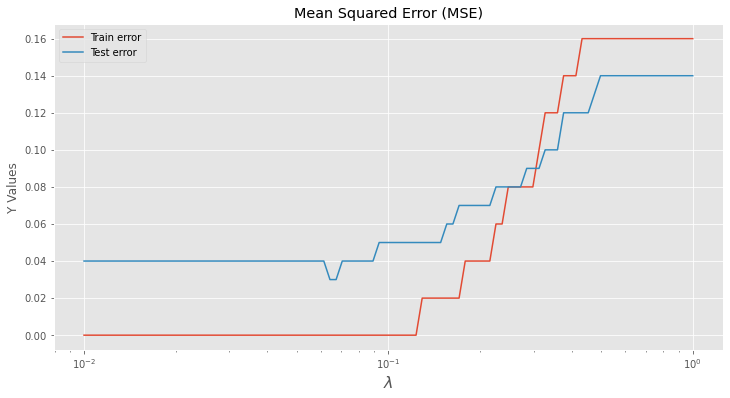

No handles with labels found to put in legend.


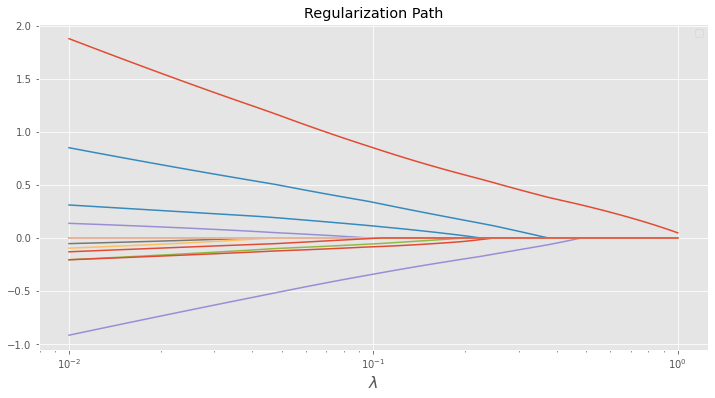

In [6]:
plot_train_test_errors(train_error, test_error, lambda_vals)
plot_regularization_path(lambda_vals, beta_vals,feature_name=None)

# Best Lambda --> Weights 

In [7]:
minimum_test_error_index = test_error.index(np.min(test_error))
best_lambd               = np.round(list(lambda_vals)[minimum_test_error_index],decimals=2)
best_lambd

0.06

In [8]:
problem = cp.Problem(cp.Maximize(objective_function(x=X,y=Y,beta=beta,lambd=best_lambd)))

print("Maximization Values          : " ,problem.solve())
print("Unconstrained Optimal Params : " ,np.round(beta.value,decimals=2))

Maximization Values          :  -0.22387562285191465
Unconstrained Optimal Params :  [ 1.06  0.45 -0.46 -0.   -0.   -0.    0.   -0.    0.17  0.   -0.    0.
 -0.    0.   -0.   -0.   -0.    0.    0.   -0.    0.   -0.    0.    0.04
 -0.    0.   -0.09  0.   -0.11  0.   -0.   -0.   -0.    0.    0.   -0.
  0.   -0.    0.    0.   -0.   -0.   -0.    0.   -0.    0.   -0.   -0.
 -0.   -0.04]


# Sklearn Classification Report (Confusion Matrix)

In [9]:
from sklearn.metrics import classification_report

# Threashold  = np.round(X_test @ beta.value ,decimals=2)
# Logistic(X) = np.round(sigmoid(X_test @ beta.value ),decimals=2 )

Prediction = np.where(np.round(sigmoid(X_test @ beta.value ),decimals=2 ) > np.round(X_test @ beta.value ,decimals=2) , 0,1)
print(classification_report(Prediction,Y_test))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95        47
           1       0.93      0.98      0.95        53

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

